# Systems of Nonlinear Equations

This code is to help us visualize the solution of nonlinear linear equations. <br>

This tutorial can be deployed in [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ChemAI-Lab/Math4Chem/blob/main/website/Lecture_Notes/Notes/Coding/nonlinear_equations.ipynb)

# Gradient Descent for Linear Equations

We will start first with a review of linear regression but solved using an iterative search approach.<br>


Here we define the a dummy linear model,
$$
f(\mathbf{w},x) = \begin{bmatrix}
b, & a \end{bmatrix}  \begin{bmatrix}
1 \\
 x \\
\end{bmatrix}
$$

As we will see, the parameters of the linear model, $\mathbf{w}^top=[a,b]$, are *free parameters*. Meaning, we usually use a metric function, commonly named to **loss function**, to search for the **optimal parameters**.<br>

. The loss function measures the distance between the predicted values, $f(x,\mathbf{w})$, and true values, $\hat{y}$,. <br>

## Least Squares
As we saw in clasee, the least squares problem can be described using the matrix notation,
$$
 {\cal L}(\mathbf{w}) =  \frac{1}{2n}\left ( \mathbf{Y} - \mathbf{X} \mathbf{w} \right )^\top \left ( \mathbf{Y} - \mathbf{X} \mathbf{w} \right )= \frac{1}{2n} \left (\mathbf{Y}^\top \mathbf{Y} - 2\mathbf{Y}^\top\mathbf{X} \mathbf{w}  + \mathbf{w}^\top \mathbf{X}^\top\mathbf{X} \mathbf{w} \right )
$$

In [1]:
# when deployed in Colab uncomment this line to install ipyml
#!pip install ipympl 

In [1]:
%matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.tri as tri

rng1 = np.random.default_rng(1)

In [4]:
# Generate some random data
x = np.linspace(0, 2, 10)
X = np.column_stack((np.ones_like(x), x))
y = X@np.array([1, 2]) + rng1.uniform(-0.75, 0.75, size=x.shape)  # add some noise

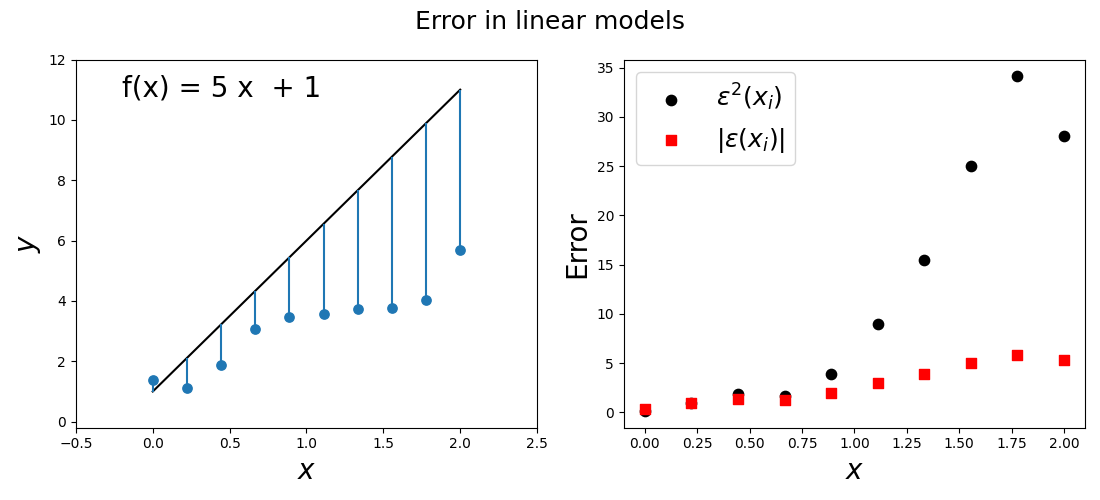

In [5]:
# change the values of a and b and see what happens
a = 5
b = 1
w = np.array([b,a])

x_grid = np.linspace(0, 2, 100)
X_grid = np.column_stack((np.ones_like(x_grid), x_grid))
y_grid = X_grid@w

y_pred = X@w # calculate values of training data
error = y_pred - y

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(11,5))
fig.suptitle('Error in linear models',fontsize=18)

# left panel 
ax1.plot(x_grid, y_grid, c='k')
for xi, yi in zip(x, y):
    y_pred_i = np.array([1,xi])@w
    error_i = yi - y_pred_i
    if error_i > 0:
        ax1.vlines(xi, y_pred_i, y_pred_i + np.abs(error_i))
    else:
        ax1.vlines(xi, y_pred_i - np.abs(error_i), y_pred_i)
ax1.text(0.1, .9, f'f(x) = {a} x  + {b}', fontsize=20, transform=ax1.transAxes)
ax1.scatter(x, y, s=45)
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-2, 12)
ax1.set_ylabel(r'$y$', fontsize=20)
ax1.set_xlabel(r'$x$', fontsize=20)

# right panel
sum_errors = 0.
for i,(xi, yi) in enumerate(zip(x, y)):
    y_pred_i = np.array([1, xi])@w
    error_i = yi - y_pred_i
    sum_errors += error_i**2

    if i == x.shape[0]-1:
        ax2.scatter(xi, error_i**2, color='k', s=55,label=r'$\epsilon^2(x_i)$')
        ax2.scatter(xi, np.abs(error_i), color='r', s=55, marker='s',label=r'$|\epsilon(x_i)|$')   
    else:
        ax2.scatter(xi, error_i**2, color='k', s=55)
        ax2.scatter(xi, np.abs(error_i), color='r', s=55, marker='s')
    

ax2.set_ylabel(r'Error', fontsize=20)
ax2.set_xlabel(r'$x$', fontsize=20)

ax1.set_ylim(-0.2,12)
plt.legend(loc=0, fontsize=18)
plt.tight_layout()


Then we will proceed to compute the Jacobian of ${\cal L}(\mathbf{w})$ with respect to the parameters of the model, $\mathbf{w}^\top = [b,a]$,
$$
 \frac{\partial }{\partial \mathbf{w}}{\cal L}(\mathbf{w}) = \frac{1}{2n} \frac{\partial }{\partial \mathbf{w}}\left (\mathbf{Y}^\top \mathbf{Y} - 2\mathbf{Y}^\top\mathbf{X} \mathbf{w}  + \mathbf{w}^\top \mathbf{X}^\top\mathbf{X} \mathbf{w} \right )
$$
which give us three unique terms,
$$
\frac{\partial }{\partial \mathbf{w}} \mathbf{Y}^\top \mathbf{Y} = \mathbf{0} \\
\frac{\partial }{\partial \mathbf{w}} \mathbf{Y}^\top\mathbf{X} \mathbf{w} = \mathbf{z} = \mathbf{X}^\top  \mathbf{Y}\\
\frac{\partial }{\partial \mathbf{w}}\mathbf{w}^\top \mathbf{X}^\top\mathbf{X} \mathbf{w} = 2 \mathbf{X}^\top\mathbf{X}\mathbf{w}
$$

If we combine these three equations and we set the Jacobian to zero, we  get,
$$
 \frac{\partial }{\partial \mathbf{w}}{\cal L}(\mathbf{w}) = \frac{1}{n} \left (- \mathbf{X}^\top  \mathbf{Y}  + \mathbf{X}^\top\mathbf{X} \mathbf{w} \right ),
$$


In [5]:
# gradient
def gradient_w(w0,x,y):
    w = - x.T@y 
    w = w + x.T@x@w0
    return w/x.shape[0]

def loss_function(w0,x,y):
    y_pred = x@w0
    loss = 0.5 * np.mean((y_pred - y)**2)
    return loss

In [6]:
def linear_model_solver(X, y):
    Xt = X.T
    A = Xt@X
    z = Xt@y
    A_inv = np.linalg.inv(A)
    w = A_inv@z
    return w  # optimal parameters

w_opt = linear_model_solver(X,y)
e_opt = loss_function(w_opt,X,y)
print(w_opt)

[1.26480696 1.75083907]


## Gradient Descent
Is a search method, used to find the minimum and maximum of functions using the gradient of a function.<br>
The central point in gradient descent is **direction of largest decrease is** $-\frac{\partial f}{\partial x}$ (the negative gradient of a function.)<br>

The general equation for gradient descent is,
$$
\mathbf{w}_{new} = \mathbf{w} - \eta \nabla_{\mathbf{w}} {\cal L}(\mathbf{w})
$$
where $\eta$ is the learning rate, and $\nabla_{\mathbf{w}} {\cal L}(\mathbf{w})$ is the gradient.

0 [-3.72807841 -4.53371946]
1 [-2.90189862 -3.52283258]
2 [-2.2594255  -2.73683665]
3 [-1.75979929 -2.12570968]
4 [-1.37124839 -1.6505558 ]
5 [-1.06906797 -1.28113051]
6 [-0.83404812 -0.99391646]
7 [-0.65125166 -0.77062711]
8 [-0.50906379 -0.59704331]
9 [-0.39845308 -0.46210862]


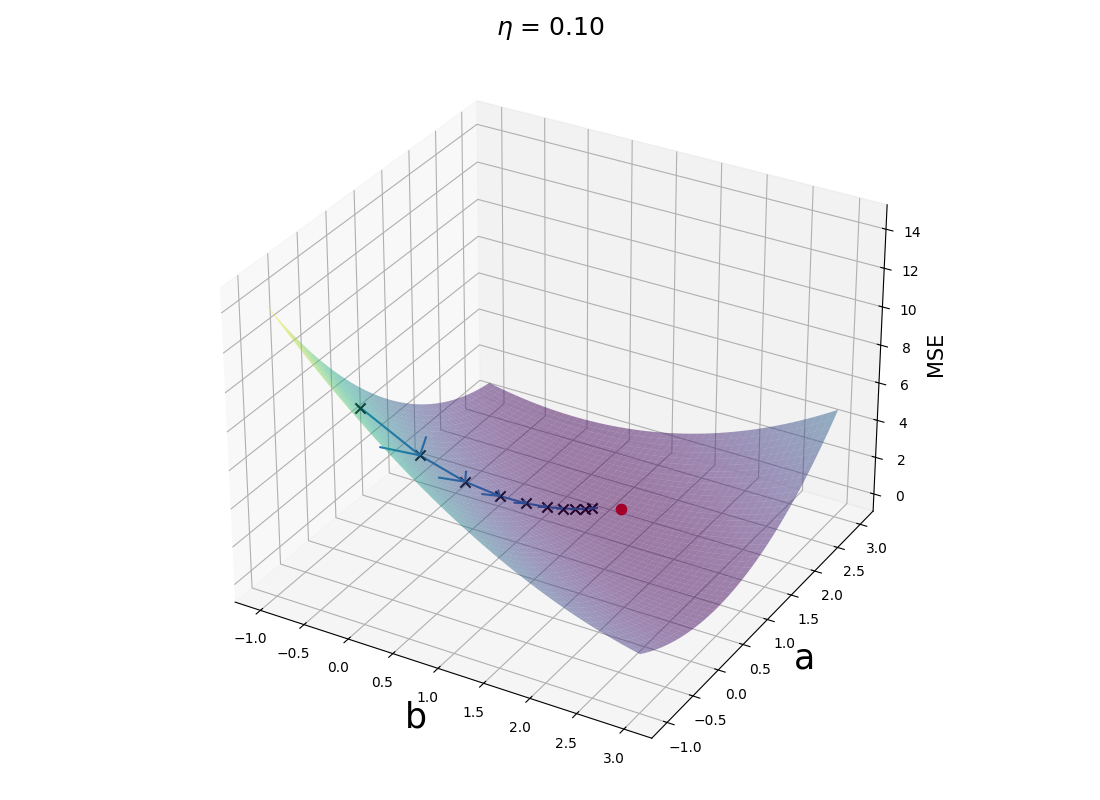

In [7]:
a_grid = np.linspace(-1, 3, 50)
b_grid = np.linspace(-1, 3, 50)
a_, b_ = np.meshgrid(a_grid, b_grid)
w_ = np.column_stack((b_.flatten(), a_.flatten()))

total_error_ = []
for wi in w_:
    ei = loss_function(wi, X, y)
    total_error_.append(ei)
total_error_ = np.array(total_error_)
total_error_ = total_error_.reshape(a_.shape)


plt.figure(figsize=(11, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(b_, a_, total_error_, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.5)

eta = 0.1
w_random = rng1.normal(-0.5, 0.5, size=(2,))
# w_random = np.ones((2,))
ax.set_title(r'$\eta$ = ' + f'{eta:.2f}',fontsize=18)

for i in range(10):
    e = loss_function(w_random,X,y)
    dw = gradient_w(w_random, X, y)
    print(i,dw)
    w_new = w_random - eta*dw
    e_new = loss_function(w_new,X,y)
    ax.quiver(w_random[0], w_random[1], e, w_new[0]-w_random[0],
            w_new[1]-w_random[1], e_new-e)
    ax.scatter(w_random[0], w_random[1], e, marker='x', s=55,color='k')
    w_random = w_new

ax.scatter(w_opt[0], w_opt[1], e_opt, marker='o', s=55, color='r')
ax.set_xlabel('b', fontsize=25)
ax.set_ylabel('a', fontsize=25)
ax.set_zlabel('MSE', fontsize=15, rotation=90)
# ax.view_init(elev=30, azim=-120)
plt.tight_layout()

In [8]:

def get_grad_trajectory(eta,n_itr):
    # w = np.random.normal(-5, 5, size=(2,))
    w = np.random.uniform(-1, 2, size=(2,))
    # w = np.ones((2,))
    w_tr = w[None, :]
    for i in range(n_itr):
        dw = gradient_w(w, X, y)
        e = loss_function(w, X, y)
        w = w - eta * dw
        w_tr = np.vstack((w_tr, w))
    return w_tr


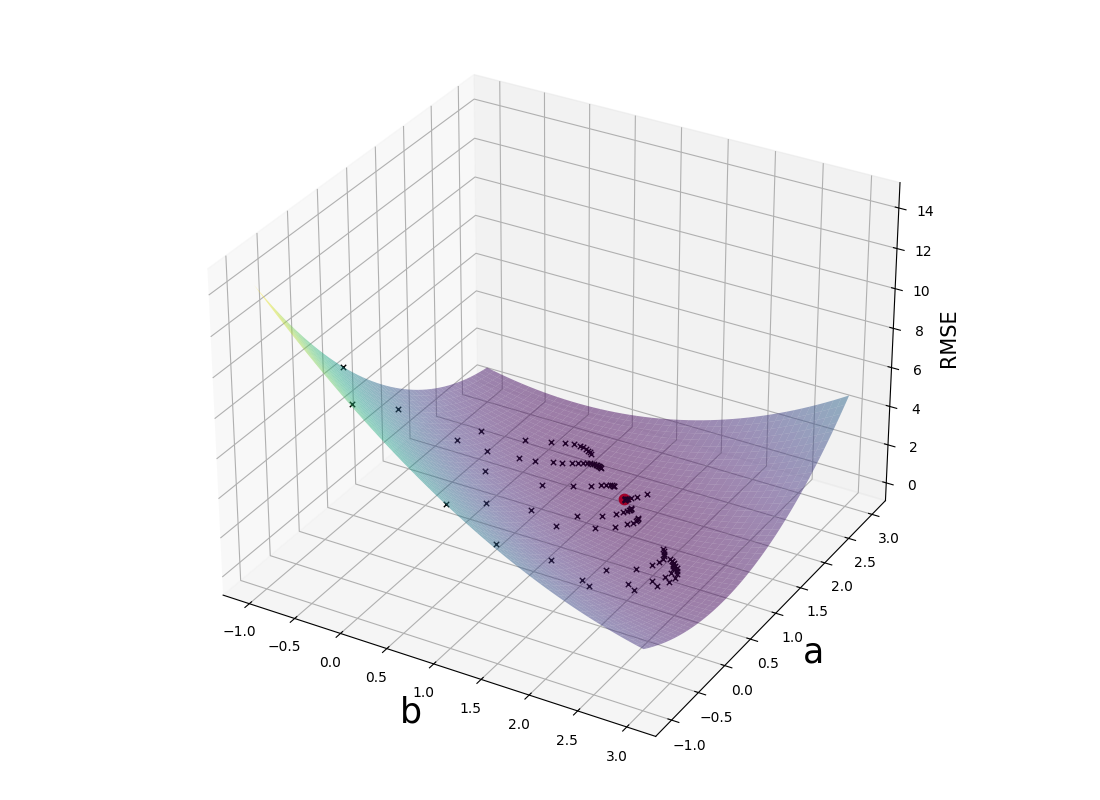

In [9]:
a_grid = np.linspace(-1, 3, 50)
b_grid = np.linspace(-1, 3, 50)
b_, a_ = np.meshgrid(a_grid, b_grid)
w_ = np.column_stack((b_.flatten(), a_.flatten()))

total_error_ = []
for wi in w_:
    ei = loss_function(wi, X, y)
    total_error_.append(ei)
total_error_ = np.array(total_error_)
total_error_ = total_error_.reshape(a_.shape)

eta = 0.2
n_itr = 10

plt.figure(figsize=(11, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(b_, a_, total_error_, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',alpha=0.5)

# random initialization
for i in range(10):
    w_tr = get_grad_trajectory(eta,n_itr)
    for wi in w_tr:
        ax.scatter(wi[0], wi[1], loss_function(wi, X,y),
            zorder=10, color='k', marker='x', s=15,linewidths=1.)  # + 1E-3 is only for display

ax.scatter(w_opt[0], w_opt[1], e_opt, marker='o', s=55, color='r')
ax.set_xlabel('b', fontsize=25)
ax.set_ylabel('a', fontsize=25)
ax.set_zlabel('RMSE', fontsize=15, rotation=90)
# ax.view_init(elev=30, azim=-120)
plt.tight_layout()

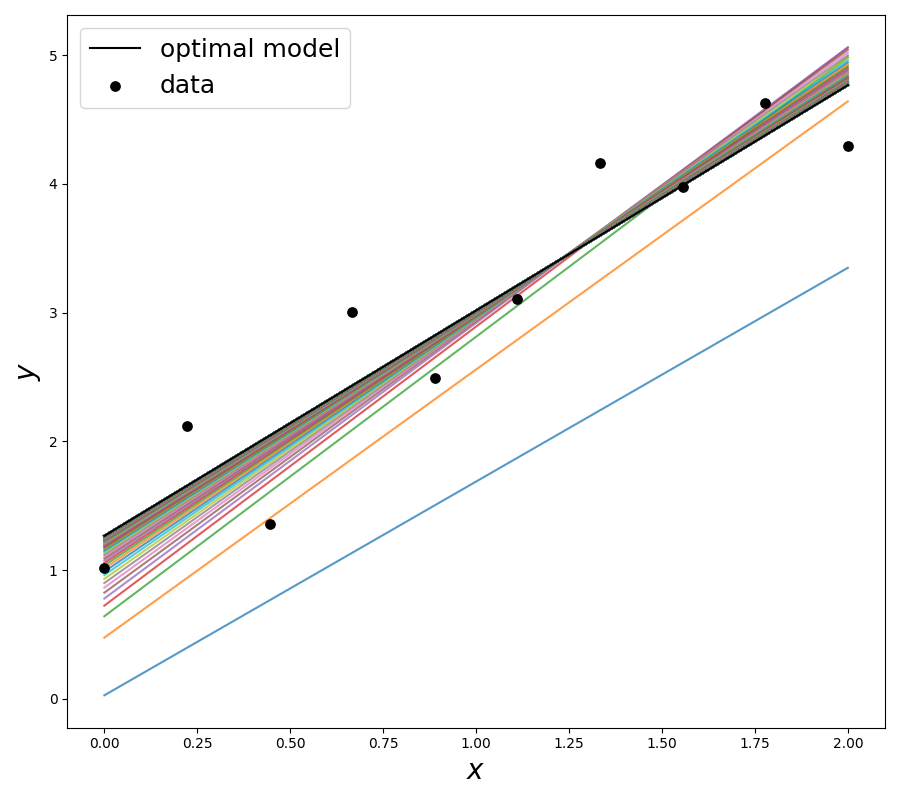

In [10]:
# change the values of a and b and see what happens
x_grid = np.linspace(0, 2, 100)
X_grid = np.column_stack((np.ones_like(x_grid), x_grid))

eta = 0.1
n_itr = 1000
w_tr = get_grad_trajectory(eta,n_itr)
 
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 8))

# left panel
for i,wi in enumerate(w_tr[::5]):
    y_pred = X_grid@wi
    ax1.plot(x_grid, y_pred, alpha=0.75)

ax1.plot(x_grid, X_grid@w_opt, c='k',label='optimal model')
ax1.scatter(x, y, c='k', s=45, label='data',zorder=4)

ax1.set_ylabel(r'$y$', fontsize=20)
ax1.set_xlabel(r'$x$', fontsize=20)

# ax1.set_ylim(-0.2, 12)
plt.legend(loc=0, fontsize=18)
plt.tight_layout()

# Gradient Descent for NonLinear Equations

Here, we will extend gradient descent for non linear equations. 
Let's do a simple example of the gradient descent for finding the minima of the following chemical equilibrium.

In [11]:
def f(x):
    z = 2*np.log(2*x) - np.log(1-x) - np.log(1-3*x)
    return z

def df_dx(x):
    dz = 4/(2*x)+1/(1-x)+9/(1-3*x)
    return dz

def error_function(x,k):
    return (f(x) - k)**2

def gradient_error_function(x,k):
    return 2*(f(x)-k)*df_dx(x)
    

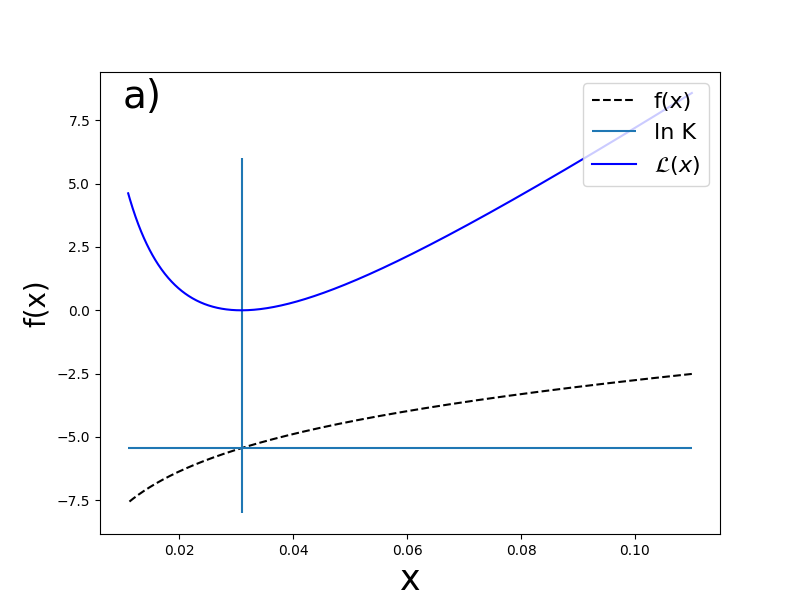

In [12]:
ln_k = np.log(4.34E-3)
x_grid = np.linspace(0.11, 0.011, 1000)
f_grid = f(x_grid)
error_grid = error_function(x_grid,ln_k)
x_opt = x_grid[np.argmin(error_grid)]

plt.figure(figsize=(8, 6))
plt.clf()
plt.text(0.01,8,'a)',fontsize=28)
plt.plot(x_grid, f_grid, c='k', label='f(x)', ls='--')
plt.vlines(x_opt,-8,6)
plt.hlines(ln_k, 0.011, 0.11, label='ln K')
plt.plot(x_grid,error_grid, c='blue', label =r'${\cal L}(x)$')
plt.xlabel('x', fontsize=25)
plt.ylabel('f(x)', fontsize=20)
plt.legend(loc=1,fontsize=16)
plt.show()

In [13]:
# x0 = 0.01 # and 
x0 = 0.075
eta = 1E-4
ln_k = np.log(4.34E-3)
x_trj = np.array(x0)
f_trj = np.array(f(x0))
for i in range(40):
    dx0 = gradient_error_function(x0,ln_k)
    e = error_function(x0, ln_k)
    print(f'Iteration {i+1}, x={x0:.5f}, f(x)={f(x0):.5f}, e={e:.5f}')
    x0 = x0 - eta * dx0
    x_trj = np.append(x_trj, x0)
    f_trj = np.append(f_trj, f(x0))

Iteration 1, x=0.07500, f(x)=-3.46139, e=3.91444
Iteration 2, x=0.05943, f(x)=-4.00217, e=2.06701
Iteration 3, x=0.04629, f(x)=-4.56234, e=0.77008
Iteration 4, x=0.03669, f(x)=-5.07012, e=0.13672
Iteration 5, x=0.03184, f(x)=-5.37529, e=0.00417
Iteration 6, x=0.03088, f(x)=-5.44024, e=0.00000
Iteration 7, x=0.03089, f(x)=-5.43986, e=0.00000
Iteration 8, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 9, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 10, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 11, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 12, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 13, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 14, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 15, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 16, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 17, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 18, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 19, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration 20, x=0.03089, f(x)=-5.43988, e=0.00000
Iteration

0.03092492492492492


Text(0, 0.5, '${\\cal L}(x)$')

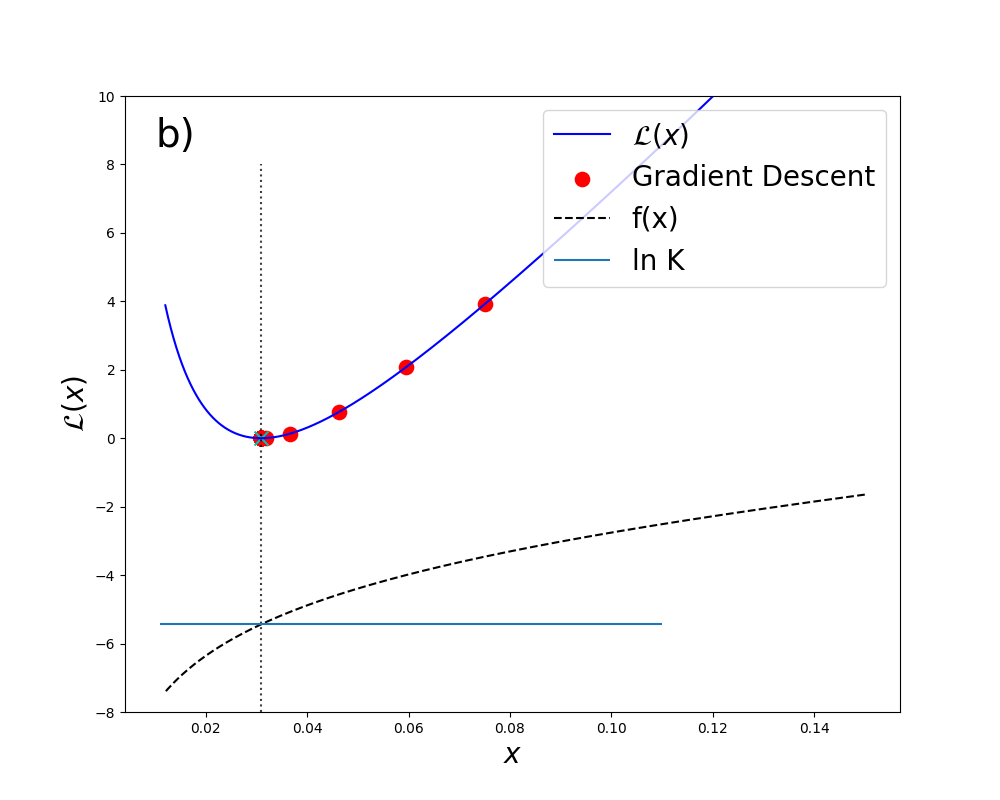

In [14]:
x_grid = np.linspace(0.15, 0.012, 1000)
f_grid = f(x_grid)
error_grid = error_function(x_grid,ln_k)
x_opt = x_grid[np.argmin(error_grid)]
print(x_opt)


plt.figure(figsize=(10,8))
plt.clf()
plt.text(0.01, 8.5, 'b)', fontsize=28)
plt.plot(x_grid, error_grid, c='blue',label=r'${\cal L}(x)$')
plt.vlines(x_opt,-8,8,ls=':',color='k',alpha=0.75)
plt.scatter(x_trj, error_function(x_trj, ln_k), s=105, c='red',label='Gradient Descent')
plt.scatter(x0, error_function(x0, ln_k), c='c', marker='x', s=100)
plt.plot(x_grid, f_grid, c='k', label='f(x)', ls='--')
plt.hlines(ln_k, 0.011, 0.11, label='ln K')
# plt.xscale('log')
plt.ylim(-8,10)
plt.legend(loc=1,fontsize=20)
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'${\cal L}(x)$', fontsize=20)

Text(0, 0.5, '$f(x)$')

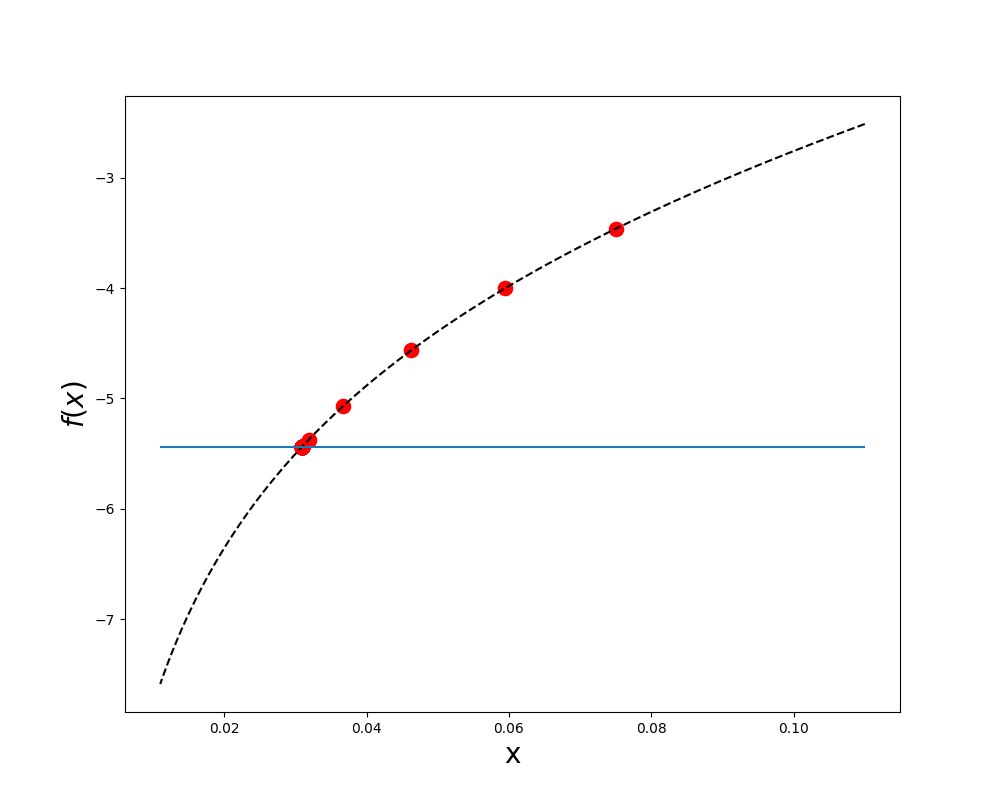

In [15]:
x_grid = np.linspace(0.11, 0.011, 1000)
error_grid = error_function(x_grid, ln_k)
f_grid = f(x_grid)
x_opt = x_grid[np.argmin(error_grid)]


f_trj = f(x_trj)
plt.figure(figsize=(10, 8))
plt.clf()
plt.scatter(x_trj, f_trj, s=105, c='red')

plt.plot(x_grid, f_grid, c='k', label='f(x)', ls='--')
plt.hlines(ln_k, 0.011, 0.11, label='ln K')
# plt.xscale('log')
plt.xlabel('x', fontsize=20)
plt.ylabel(r'$f(x)$', fontsize=20)

## 3D gradient descent


In [16]:
def f_residuals(x,m0,k):
    xa1 = x[0]
    xa2 = x[1]
    xw = x[2]
    ka1 = k[0]
    ka2 = k[1]
    kw = k[2]
    
    g1 = ka1*(m0 + xa1) - (xa1 - xa2)*(xa1 + xa2 + xw)
    g2 = ka2*(xa1 - xa2) - (xa2)*(xa1 + xa2 + xw)
    gw = kw -xw*(xa1 + xa2 + xw)
    return np.array([g1,g2,gw])

def jacobian_f_r(x,m0,k):
    xa1 = x[0]
    xa2 = x[1]
    xw = x[2]
    ka1 = k[0]
    ka2 = k[1]
    kw = k[2]
    
    dg1_dxa1 = -ka1 - 2*xa1 - xw
    dg1_dxa2 = 2*xa2 + xw
    dg1_dxw = -xa1 + xa2
    
    dg2_dxa1 = ka2 - xa2
    dg2_dxa2 = -ka2 + 2*xa2 - xa1 - xw
    dg2_dxw = -xa2
    
    dg3_dxa1 = -xw
    dg3_dxa2 = -xw
    dg3_dxw = -xa1 - xa2 - 2*xw
    
    return np.array([[dg1_dxa1, dg1_dxa2, dg1_dxw], 
                     [dg2_dxa1, dg2_dxa2, dg2_dxw], 
                     [dg3_dxa1, dg3_dxa2, dg3_dxw]])

def error_function(x0, m0, k):
    g = f_residuals(x0,m0,k)
    return 0.5 * np.dot(g,g)

def gradient_error_function(x0, m0, k):
    g = f_residuals(x0, m0, k)
    jac_g = jacobian_f_r(x0, m0, k)
    return jac_g.T @ g

In [17]:
k = np.array([5.6E-2,1.5E-4,1E-14])
m0 = 1E-4
# x0 = np.array([9.8E-5,4.99E-5,6.67E-11])
x0 = np.random.normal(-5,5,size=(3,))*1E-5

print(f_residuals(x0, m0, k))
print(error_function(x0, m0, k))

[ 3.25600676e-06 -5.75455305e-09 -4.87110082e-09]
5.3008184463867114e-12


In [18]:
eta = 1E1
x0_trj = np.array(x0[None,:])
error_trj = np.array(error_function(x0, m0, k))
dx0_norm_trj = np.array(np.linalg.norm(gradient_error_function(x0, m0,k)))
for i in range(2000):
    dx0 = gradient_error_function(x0, m0,k)
    e = error_function(x0, m0,k)
    print(f'Itr {i+1}, e = ', e , 'x = ',x0, '|dx| = ', np.linalg.norm(dx0))
    x0 = x0 - eta * dx0
    x0_trj = np.vstack((x0_trj, x0))
    error_trj = np.append(error_trj, e)
    dx0_norm_trj = np.append(dx0_norm_trj, np.linalg.norm(dx0))

Itr 1, e =  5.3008184463867114e-12 x =  [-4.18006699e-05 -1.04457486e-05 -4.83988203e-05] |dx| =  1.819079122764458e-07
Itr 2, e =  5.638483538000991e-12 x =  [-3.99815924e-05 -1.04434948e-05 -4.83998333e-05] |dx| =  1.876244770163756e-07
Itr 3, e =  5.997658075108376e-12 x =  [-3.81053493e-05 -1.04411702e-05 -4.84008176e-05] |dx| =  1.9352107955799886e-07
Itr 4, e =  6.379712181582191e-12 x =  [-3.61701403e-05 -1.04387728e-05 -4.84017684e-05] |dx| =  1.9960341491132347e-07
Itr 5, e =  6.7861032527268956e-12 x =  [-3.41741079e-05 -1.04363000e-05 -4.84026804e-05] |dx| =  2.058773598125695e-07
Itr 6, e =  7.218381513707837e-12 x =  [-3.21153360e-05 -1.04337497e-05 -4.84035481e-05] |dx| =  2.1234897862289166e-07
Itr 7, e =  7.678195931955133e-12 x =  [-2.99918480e-05 -1.04311194e-05 -4.84043653e-05] |dx| =  2.1902452942483433e-07
Itr 8, e =  8.167300506077419e-12 x =  [-2.78016045e-05 -1.04284065e-05 -4.84051256e-05] |dx| =  2.2591047032353284e-07
Itr 9, e =  8.687560955255289e-12 x =  [-

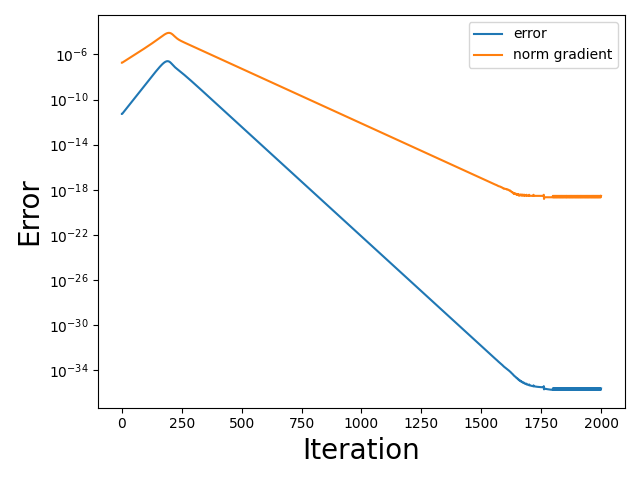

In [19]:
plt.figure(0)
plt.clf()
plt.plot(np.arange(error_trj.shape[0]),error_trj,label='error')
plt.plot(np.arange(error_trj.shape[0]), dx0_norm_trj, label='norm gradient')
plt.yscale('log')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

[[-4.18006699e-05 -1.04457486e-05 -4.83988203e-05]
 [-3.99815924e-05 -1.04434948e-05 -4.83998333e-05]
 [-3.81053493e-05 -1.04411702e-05 -4.84008176e-05]
 ...
 [ 5.61002182e-02  1.49204236e-04  1.77805705e-13]
 [ 5.61002182e-02  1.49204236e-04  1.77805607e-13]
 [ 5.61002182e-02  1.49204236e-04  1.77805755e-13]]


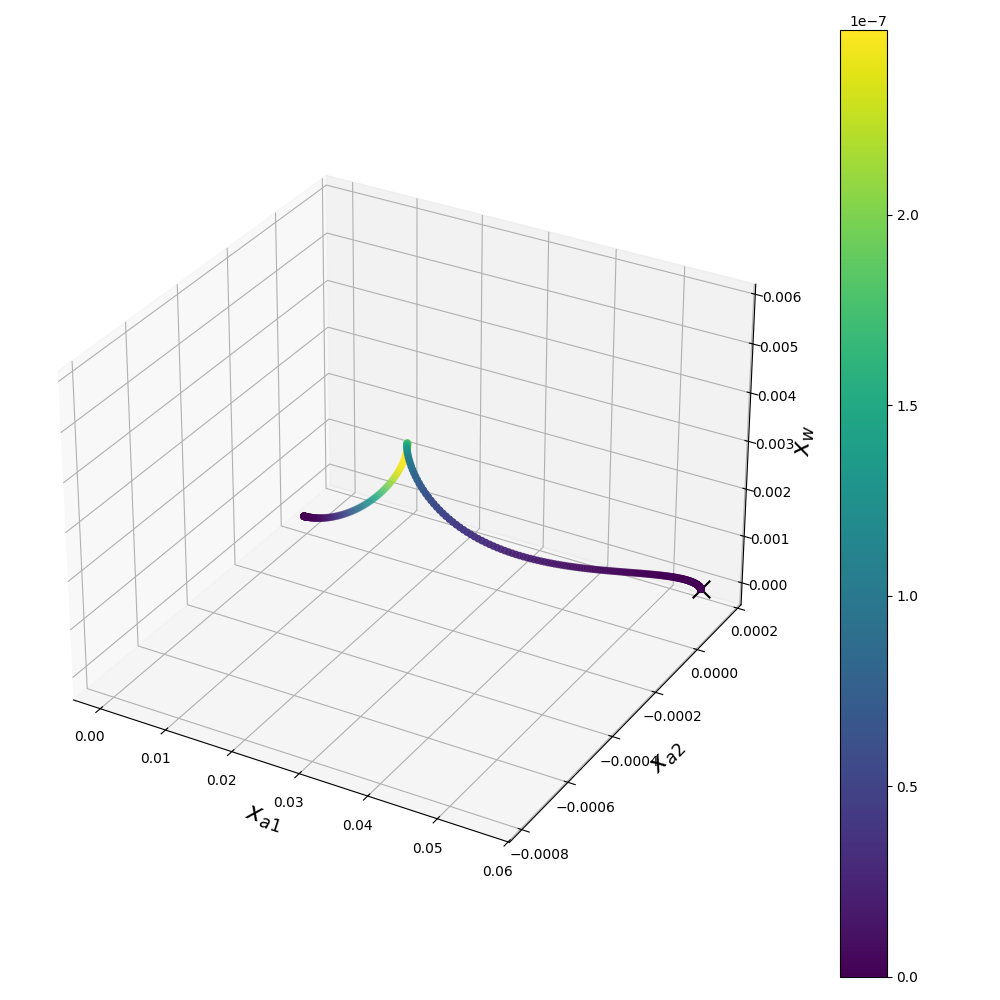

In [20]:
print(x0_trj)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection="3d")
xs = np.random.rand(100)
ys = np.random.rand(100)
zs = np.random.rand(100)
ax.scatter(x0[0], x0[1], x0[2], c='k', marker='x',s=160)
sc = ax.scatter(x0_trj[:, 0], x0_trj[:, 1], x0_trj[:, 2], c=error_trj, cmap='viridis')
plt.colorbar(sc)
ax.set_xlabel(r'$x_{a1}$', fontsize=18)
ax.set_ylabel(r'$x_{a2}$', fontsize=18)
ax.set_zlabel(r'$x_{w}$', fontsize=18)
plt.tight_layout()
plt.show()

# Newton's method

Newton's method is an alternative algorithm to solve non-linear equations of the from, $f(x) = 0$ or $f(x) = c$, where $c$ is a constant. <br>
For our 1D system of chemical equilibrium, $f(x) = lnK$, which is similar to this style of problems.

Each iteration of Newton's method is given by, 
$$
x_{n+1} = x_n -\left(\frac{\partial f(x)}{\partial x} \bigg|_{x_n}\right)^{-1}\left( f(x_n) - c\right )$$

We can start by initializing $x_0$ and then iteratively apply the Newton's method to find the root of the function.

Here is the Python code for Newton's method for our 1D system of chemical equilibrium.<br>


![Newton's Method Animation](https://github.com/ChemAI-Lab/Math4Chem/raw/main/website/Assigments/NewtonIteration_Ani.gif)<br>
Animaiton of Newton's Method from [Wikipedia](https://en.wikipedia.org/wiki/Newton%27s_method)

In [21]:
def f(x):
    z = 2*np.log(2*x) - np.log(1-x) - np.log(1-3*x)
    return z


def df_dx(x):
    dz = 4/(2*x)+1/(1-x)+9/(1-3*x)
    return dz

In [22]:
def newton_step(x0,dx0,f0,f_value):
    delta_f = f0 - f_value
    x1 = x0 - delta_f/dx0
    return x1

In [23]:
x0 = 0.1
ln_k = np.log(4.34E-3)

x_trj = np.array(x0)
f_trj = np.array(f(x0))
for i in range(10):
    f0 = f(x0)
    dx0 = df_dx(x0) 
    x_trj = np.append(x_trj, x0)
    f_trj = np.append(f_trj, f0)
    print(i, x0)
    x0 = newton_step(x0,dx0,f0,ln_k)

0 0.1
1 0.021013291760427363
2 0.028694160344954638
3 0.03064034238887864
4 0.030865448810746585
5 0.03088578959178001
6 0.03088757189495178
7 0.030887727626401375
8 0.03088774123032392
9 0.030887742418669147


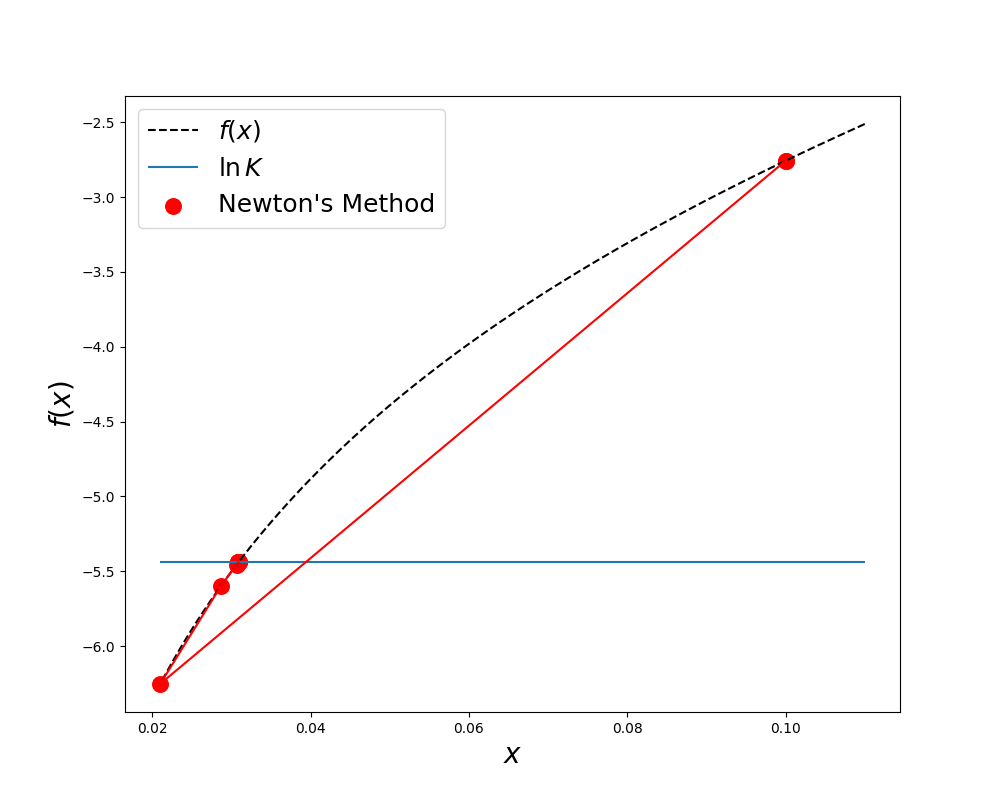

In [24]:
x_grid = np.linspace(0.11,0.021,1000)
f_grid = f(x_grid)

plt.figure(figsize=(10,8))
plt.clf()
plt.plot(x_grid, f_grid, c='k', label=r'$f(x)$', ls='--')
plt.hlines(ln_k,0.021,0.11,label=r'$\ln K$')
plt.scatter(x_trj,f_trj,c='r',marker='o',s=125,label="Newton's Method")
plt.plot(x_trj,f_trj,c='r')
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$f(x)$', fontsize=20)
plt.legend(fontsize=18)
plt.show()

## Newton-Raphson to solve systems of $k$ equations
We will start with $k=3$, meaning three simultaneous equilibria.<br>

We are going to extend the Newton's method for a single function for these two simultaneous equilibria.<br>
As we saw in class, when combined we get the following equation for each iteration,
$$
\mathbf{x}_{n+1} = \underbrace{\begin{bmatrix}
x^{(n)}_1\\
x^{(n)}_2 \\
x^{(n)}_3
\end{bmatrix}}_{\mathbf{x}_{n}} - J_{\mathbf{f}(\mathbf{x}_n)}^{-1}\begin{bmatrix}
f_1(\mathbf{x}_{n}) - \ln K_1\\
f_2(\mathbf{x}_{n})- \ln K_2 \\
f_3(\mathbf{x}_{n})- \ln K_3
\end{bmatrix}
$$
where $J_{\mathbf{f}(\mathbf{x})}^{-1}$ is the inverse of the Jacobian matrix evaluated at the point $\mathbf{x}_n$
$$
J_{\mathbf{f}(\mathbf{x}_n)} = \begin{bmatrix}
\frac{\partial f_1(\mathbf{x})}{\partial x_1}|_{\mathbf{x}_n} & \frac{\partial f_1(\mathbf{x})}{\partial x_2}|_{\mathbf{x}_n}  & \frac{\partial f_1(\mathbf{x})}{\partial x_3}|_{\mathbf{x}_n}\\
\frac{\partial f_2(\mathbf{x})}{\partial x_2}|_{\mathbf{x}_n} & \frac{\partial f_2(\mathbf{x})}{\partial x_2}|_{\mathbf{x}_n} & \frac{\partial f_2(\mathbf{x})}{\partial x_3}|_{\mathbf{x}_n} \\
\frac{\partial f_3(\mathbf{x})}{\partial x_1}|_{\mathbf{x}_n} & \frac{\partial f_3(\mathbf{x})}{\partial x_2}|_{\mathbf{x}_n} & \frac{\partial f_3(\mathbf{x})}{\partial x_3}|_{\mathbf{x}_n}
\end{bmatrix}
$$




For the three equilibrium, we can defined the following functions,
$$
\mathbf{f}(\mathbf{x}) = \begin{bmatrix}
f_1(\mathbf{x})\\
f_2(\mathbf{x}) \\
f_3(\mathbf{x})
\end{bmatrix}
= \begin{bmatrix}
K_{a1}(m_0-x_{a1}) - (x_{a1}-x_{a2})(x_{a1}+ x_{a2} + x_{w}) \\
K_{a2}(x_{a1} - x_{a2}) - (x_{a2})(x_{a1}+ x_{a2} + x_{w})\\
K_{w} - (x_w)(x_{a1}+ x_{a2} + x_{w})
\end{bmatrix} = \begin{bmatrix}
0\\
0 \\
0
\end{bmatrix}
$$

The Jacobian of $\mathbf{f}$ is, 
$$
J_{\mathbf{f}(\mathbf{x})} = 
\begin{bmatrix}
-K_{a1}-2x_{a2}-x_w & 2x_{a2}+x_w  & -x_{a1} + x_{a2}  \\
K_{a2}-x_{a2} & -K_{a2}-2x_{a2} - x_{a1} - x_w & -x_{a2} \\
-x_w & -x_w & -x_{a1} - x_{a2} - x_{w}
 &  & 
\end{bmatrix} 
$$

In [25]:
def f(x, m0, k):
    xa1 = x[0]
    xa2 = x[1]
    xw = x[2]
    ka1 = k[0]
    ka2 = k[1]
    kw = k[2]

    g1 = ka1*(m0 + xa1) - (xa1 - xa2)*(xa1 + xa2 + xw)
    g2 = ka2*(xa1 - xa2) - (xa2)*(xa1 + xa2 + xw)
    gw = kw - xw*(xa1 + xa2 + xw)
    return np.array([g1, g2, gw])


def jacobian_f(x, m0, k):
    xa1 = x[0]
    xa2 = x[1]
    xw = x[2]
    ka1 = k[0]
    ka2 = k[1]
    kw = k[2]

    dg1_dxa1 = -ka1 - 2*xa1 - xw
    dg1_dxa2 = 2*xa2 + xw
    dg1_dxw = -xa1 + xa2

    dg2_dxa1 = ka2 - xa2
    dg2_dxa2 = -ka2 + 2*xa2 - xa1 - xw
    dg2_dxw = -xa2

    dg3_dxa1 = -xw
    dg3_dxa2 = -xw
    dg3_dxw = -xa1 - xa2 - 2*xw

    return np.array([[dg1_dxa1, dg1_dxa2, dg1_dxw],
                     [dg2_dxa1, dg2_dxa2, dg2_dxw],
                     [dg3_dxa1, dg3_dxa2, dg3_dxw]])


def error_function(x0, m0, k):
    g = f(x0, m0, k)
    return 0.5 * np.dot(g, g)


In [26]:
def newton_step_vector(x0, m0, k):
    f_values = f(x0, m0, k)
    jac_f = jacobian_f(x0, m0, k)
    jac_f_inv = np.linalg.inv(jac_f)
    x = x0 - jac_f_inv@(f_values)
    return x

In [27]:
k = np.array([5.6E-2, 1.5E-4, 1E-14])
ln_k = np.log(k)
m0 = 1E-4
x0 = np.array([9.8E-5, 4.99E-5, 6.67E-11])

x_trj = x0[None,:]
error_trj = np.array(error_function(x0, m0, k))
for i in range(100):
    x0 = newton_step_vector(x0, m0, k)
    print(f'Iteration {i+1}: {x0}')
    x_trj = np.vstack((x_trj, x0))
    e = error_function(x0, m0, k)
    error_trj = np.append(error_trj, e)

Iteration 1: [ 2.95417653e-04  1.82128693e-04 -8.10506830e-11]
Iteration 2: [ 6.79222873e-04 -8.32071695e-04 -8.60523103e-11]
Iteration 3: [ 1.43423258e-03 -4.94782245e-04 -6.80376565e-10]
Iteration 4: [2.85202679e-03 1.53421652e-04 1.50690159e-09]
Iteration 5: [ 5.39959975e-03  1.29294622e-04 -1.26190107e-09]
Iteration 6: [9.57399931e-03 1.59935630e-04 9.61557384e-10]
Iteration 7: [ 1.55635285e-02  1.38221432e-04 -5.88497310e-10]
Iteration 8: [2.28512461e-02 1.53076344e-04 2.74335343e-10]
Iteration 9: [ 3.03546206e-02  1.46917521e-04 -8.89724570e-11]
Iteration 10: [3.70728378e-02 1.49256217e-04 1.99315976e-11]
Iteration 11: [ 4.25075615e-02  1.48902806e-04 -2.64132591e-12]
Iteration 12: [4.66145882e-02 1.49059506e-04 4.88751479e-13]
Iteration 13: [4.95839763e-02 1.49103748e-04 1.82806218e-13]
Iteration 14: [5.16704523e-02 1.49138384e-04 1.93403925e-13]
Iteration 15: [5.31097057e-02 1.49160649e-04 1.87605466e-13]
Iteration 16: [5.40906298e-02 1.49175339e-04 1.84306787e-13]
Iteration 17

(101, 3) (101,)


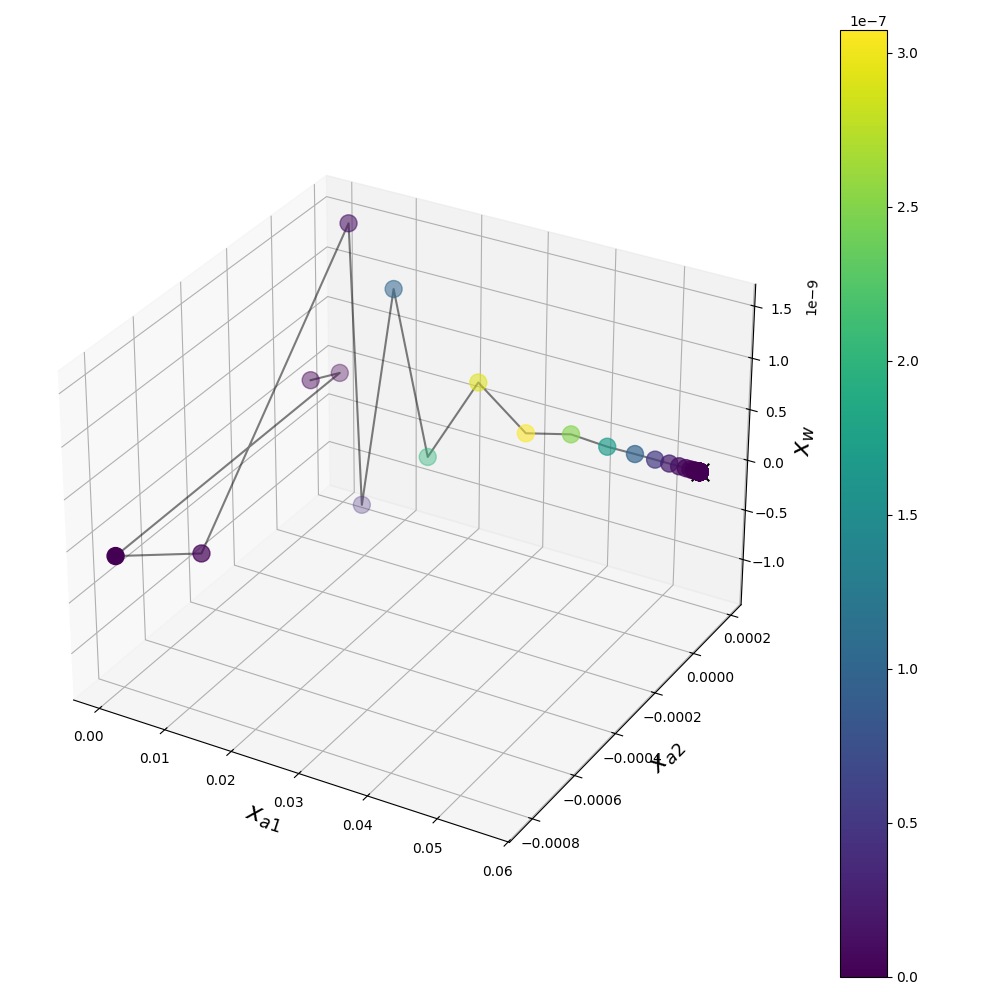

In [28]:
print(x_trj.shape,error_trj.shape)
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(projection="3d")
xs = np.random.rand(100)
ys = np.random.rand(100)
zs = np.random.rand(100)
ax.scatter(x0[0], x0[1], x0[2], c='k', marker='x', s=160)
ax.plot(x_trj[:, 0], x_trj[:, 1],
                x_trj[:, 2], c='k',alpha=0.5)
sc = ax.scatter(x_trj[:, 0], x_trj[:, 1],
                x_trj[:, 2], c=error_trj, cmap='viridis',s=150)
plt.colorbar(sc)
ax.set_xlabel(r'$x_{a1}$', fontsize=18)
ax.set_ylabel(r'$x_{a2}$', fontsize=18)
ax.set_zlabel(r'$x_{w}$', fontsize=18)
plt.tight_layout()
plt.show()

# Extra temporary

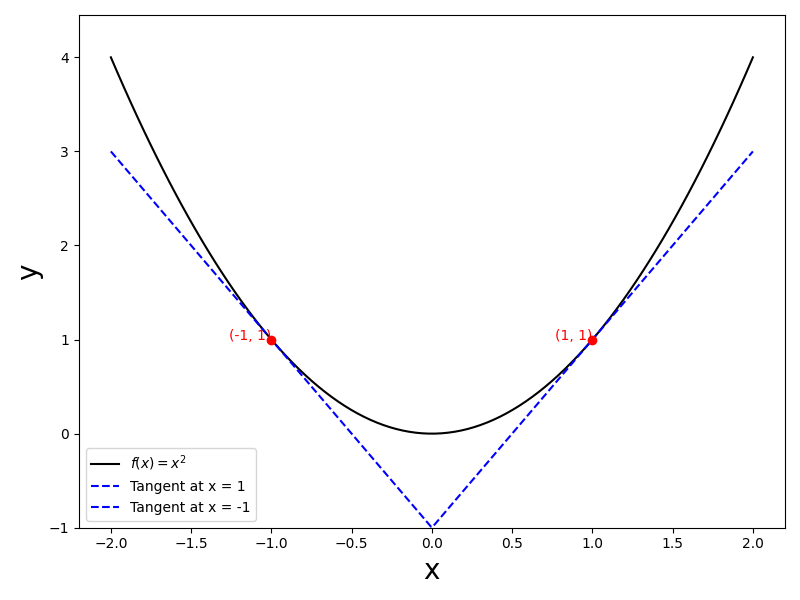

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function and its derivative


def f(x):
    return x ** 2


def f_prime(x):
    return 2 * x


# Choose the point where you want to find the tangent
a = 1  # You can change this value to any point of interest
tangent_slope = f_prime(a)
tangent_intercept = f(a) - tangent_slope * a

# Define the tangent line function


def tangent_line(x):
    return tangent_slope * x + tangent_intercept


# Generate x values for plotting
x = np.linspace(-2, 2, 100)
y = f(x)
tangent_y = tangent_line(x)

# Plot the function and its tangent line
plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r"$f(x) = x^2$", color="k")
plt.plot(x, tangent_y, label=f"Tangent at x = {
         a}", color="blue", linestyle="--")
# Highlight the point of tangency
plt.scatter(a, f(a), color="red", zorder=5)
plt.text(a, f(a), f"({a}, {f(a)})", ha="right", color="red")

a = -1  # You can change this value to any point of interest
tangent_slope = f_prime(a)
tangent_intercept = f(a) - tangent_slope * a
tangent_y = tangent_line(x)
plt.plot(x, tangent_y, label=f"Tangent at x = {
         a}", color="blue", linestyle="--")

# Highlight the point of tangency
plt.scatter(a, f(a), color="red", zorder=5)
plt.text(a, f(a), f"({a}, {f(a)})", ha="right", color="red")

# Add labels and legend
plt.ylim(-1)
plt.xlabel("x",fontsize=20)
plt.ylabel("y", fontsize=20)
plt.legend()
plt.tight_layout()
plt.show()

# OLD CODE

## Newton-Raphson to solve systems of $k$ equations
We will start with $k=3$, meaning thre simultaneous equilibria.
$$
\mathbf{f}(\mathbf{x}) = \begin{bmatrix}
f_1(\mathbf{x})\\
f_2(\mathbf{x})\\
f_3(\mathbf{x})
\end{bmatrix} = \begin{bmatrix}
\ln K_1\\
\ln K_2 \\
\ln K_3
\end{bmatrix}
$$
where 
$$
\mathbf{x} = \begin{bmatrix}
x_1\\
x_2\\
x_3
\end{bmatrix}
$$
and 
$$
\begin{bmatrix}
f_1(\mathbf{x})\\
f_2(\mathbf{x})\\
f_3(\mathbf{x})
\end{bmatrix} = \begin{bmatrix}
\ln Q_1(\mathbf{x})\\
\ln Q_2(\mathbf{x}) \\
\ln Q_3(\mathbf{x})
\end{bmatrix}
$$

We are going to extend the Newton's method for a single function for these two simultaneous equilibria.<br>
As we saw in class, when combined we get the following equation for each iteration,
$$
\mathbf{x}_{n+1} = \underbrace{\begin{bmatrix}
x^{(n)}_1\\
x^{(n)}_2 \\
x^{(n)}_3
\end{bmatrix}}_{\mathbf{x}_{n}} - J_{\mathbf{f}(\mathbf{x}_n)}^{-1}\begin{bmatrix}
f_1(\mathbf{x}_{n}) - \ln K_1\\
f_2(\mathbf{x}_{n})- \ln K_2 \\
f_3(\mathbf{x}_{n})- \ln K_3
\end{bmatrix}
$$
where $J_{\mathbf{f}(\mathbf{x})}^{-1}$ is the inverse of the Jacobian matrix evaluated at the point $\mathbf{x}_n$
$$
J_{\mathbf{f}(\mathbf{x}_n)} = \begin{bmatrix}
\frac{\partial f_1(\mathbf{x})}{\partial x_1}|_{\mathbf{x}_n} & \frac{\partial f_1(\mathbf{x})}{\partial x_2}|_{\mathbf{x}_n}  & \frac{\partial f_1(\mathbf{x})}{\partial x_3}|_{\mathbf{x}_n}\\
\frac{\partial f_2(\mathbf{x})}{\partial x_2}|_{\mathbf{x}_n} & \frac{\partial f_2(\mathbf{x})}{\partial x_2}|_{\mathbf{x}_n} & \frac{\partial f_2(\mathbf{x})}{\partial x_3}|_{\mathbf{x}_n} \\
\frac{\partial f_3(\mathbf{x})}{\partial x_1}|_{\mathbf{x}_n} & \frac{\partial f_3(\mathbf{x})}{\partial x_2}|_{\mathbf{x}_n} & \frac{\partial f_3(\mathbf{x})}{\partial x_3}|_{\mathbf{x}_n}
\end{bmatrix}
$$

 we will reuse the equations for the previous example, but instead of using $K=\frac{x_1}{x_2}$, so that $f(x_1,x_2) = x_2 K - x_1$. <br>
 We will use $f(x_1,x_2) = \ln K = \ln(x_1) - \ln(x_2)$.

 For the three prev. equilibrium, we get, 
$$
\begin{bmatrix}
\ln K_1\\
\ln K_2 \\
\ln K_3
\end{bmatrix} = \begin{bmatrix}
f_1(\mathbf{x}_{n})\\
f_2(\mathbf{x}_{n}) \\
f_3(\mathbf{x}_{n})
\end{bmatrix} = \begin{bmatrix}
\ln(x_{a1}-x_{a2}) + \ln(x_{a1}+ x_{a2} + x_{w}) - \ln(m_0-x_{a1})\\
\ln(x_{a2}) + \ln(x_{a1}+ x_{a2} + x_{w}) - \ln(x_{a1} - x_{a2})\\
\ln(x_{w}) + \ln(x_{a1}+ x_{a2} + x_{w})
\end{bmatrix}
$$

The Jacobian of $\mathbf{f}$ is, 
$$
J_{\mathbf{f}(\mathbf{x})} = 
\begin{bmatrix}
\frac{1}{x_{a1} - x_{a2}} + \frac{1}{x_{a1} + x_{a2} + x_w} + \frac{1}{m_0 - x_{a1}} & -\frac{1}{x_{a1} - x_{a2}} + \frac{1}{x_{a1} + x_{a2} + x_w} & \frac{1}{x_{a1} + x_{a2} + x_w} \\
\frac{1}{x_{a1} + x_{a2} + x_w} - \frac{1}{x_{a1} - x_{a2}} & \frac{1}{x_{a2}} + \frac{1}{x_{a1} + x_{a2} + x_w} + \frac{1}{x_{a1} - x_{a2}} & \frac{1}{x_{a1} + x_{a2} + x_w}\\
\frac{1}{x_{a1} + x_{a2} + x_w} & \frac{1}{x_{a1} + x_{a2} + x_w} & \frac{1}{x_w} + \frac{1}{x_{a1} + x_{a2} + x_w}
\end{bmatrix} 
$$

In [30]:
# we will reuse the equations for the previous example
def f(x, m0):
    xa1 = x[0]
    xa2 = x[1]
    xw = x[2]
    x_sum = np.sum(x)

    f1 = np.log(xa1 - xa2) + np.log(x_sum) - np.log(m0 - xa1)
    f2 = np.log(xa2) + np.log(x_sum) - np.log(xa1 - xa2)
    fw = np.log(xw) + np.log(x_sum)
    return np.array([f1, f2, fw])


def jacobian_f(x, m0):
    xa1 = x[0]
    xa2 = x[1]
    xw = x[2]
    x_sum = np.sum(x)

    df1_dxa1 = 1/(xa1-xa2) + 1/x_sum + 1/(m0-xa1)
    df1_dxa2 = -1/(xa1-xa2) + 1/x_sum
    df1_dxw = 1/x_sum

    df2_dxa1 = 1/x_sum - 1/(xa1-xa2)
    df2_dxa2 = 1/xa2 + 1/x_sum + 1/(xa1-xa2)
    df2_dxw = 1/x_sum

    df3_dxa1 = 1/x_sum
    df3_dxa2 = 1/x_sum
    df3_dxw = 1/xa2 + 1/x_sum

    return np.array([[df1_dxa1, df1_dxa2, df1_dxw],
                     [df2_dxa1, df2_dxa2, df2_dxw],
                     [df3_dxa1, df3_dxa2, df3_dxw]])
    
def newton_step_vector(x0,m0,ln_k):
    f_values = f(x0,m0)
    jac_f = jacobian_f(x0,m0)
    jac_f_inv = np.linalg.inv(jac_f)
    print(jac_f_inv)
    print(jac_f_inv)
    print(f_values)
    x = x0 - jac_f_inv@(f_values - ln_k)
    # x = np.maximum(1E-14,x)
    return x

In [31]:
k = np.array([5.6E-2, 1.5E-4, 1E-14])
ln_k = np.log(k)
m0 = 2E4
x0 = np.array([9.8E-5,4.99E-5,6.67E-11])

for i in range(10):
    x0 = newton_step_vector(x0, m0, ln_k)
    print(f'Iteration {i+1}: {x0}')

[[ 4.88991992e-05  1.67677490e-05 -1.65661254e-05]
 [ 1.67677490e-05  2.75430112e-05 -1.11784944e-05]
 [-1.65661254e-05 -1.11784944e-05  4.43107528e-05]]
[[ 4.88991992e-05  1.67677490e-05 -1.65661254e-05]
 [ 1.67677490e-05  2.75430112e-05 -1.11784944e-05]
 [-1.65661254e-05 -1.11784944e-05  4.43107528e-05]]
[-28.66468967  -8.78223491 -32.2497899 ]
Iteration 1: [ 0.00135813  0.00048144 -0.00042626]
[[ 6.37696636e-04  1.04344552e-04 -1.88545370e-04]
 [ 1.04344552e-04  2.84057181e-04 -9.86890615e-05]
 [-1.88545370e-04 -9.86890615e-05  4.32090774e-04]]
[[ 6.37696636e-04  1.04344552e-04 -1.88545370e-04]
 [ 1.04344552e-04  2.84057181e-04 -9.86890615e-05]
 [-1.88545370e-04 -9.86890615e-05  4.32090774e-04]]
[-23.50466441  -7.16120809          nan]
Iteration 2: [nan nan nan]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[nan nan nan]
Iteration 3: [nan nan nan]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]

/var/folders/x7/dwvwf5c92p71ds8swvmz8rlh0000gn/T/ipykernel_24170/1964566918.py:10: RuntimeWarning: invalid value encountered in log
  fw = np.log(xw) + np.log(x_sum)
